In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load data from CSV
try:
    df = pd.read_csv('/content/data.csv')
except FileNotFoundError:
    print("Error: CSV file not found. Please check the file path.")
    exit()

In [4]:
# Basic Data Information
print("\n--- Data Information ---")
print(df.info())

# Descriptive Statistics
print("\n--- Descriptive Statistics ---")
print(df.describe())


--- Data Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Provider Name              4999 non-null   object
 1   State                      4999 non-null   object
 2   City                       4999 non-null   object
 3   Claims Paid for Testing    4999 non-null   int64 
 4   Claims Paid for Treatment  4999 non-null   int64 
 5   Claims Paid for Vaccine    4999 non-null   int64 
 6   Georeferenced Column       4984 non-null   object
dtypes: int64(3), object(4)
memory usage: 273.5+ KB
None

--- Descriptive Statistics ---
       Claims Paid for Testing  Claims Paid for Treatment  \
count             4.999000e+03               4.999000e+03   
mean              2.484016e+05               9.546674e+04   
std               4.114179e+06               9.245314e+05   
min               0.000000e+00          

In [5]:
# Calculate Total Reimbursement
df['Total Reimbursement'] = (
    df['Claims Paid for Testing'] +
    df['Claims Paid for Treatment'] +
    df['Claims Paid for Vaccine']
)
df['Total Reimbursement']

,Total Reimbursement
0,979
1,1060
2,350
3,14200
4,13388
...,...
4994,4719
4995,425
4996,25336
4997,20607


In [6]:
# Check basic statistics of Total Reimbursement
print(df['Total Reimbursement'].describe())

# Check for missing or invalid values
print(df['Total Reimbursement'].isnull().sum())

# Check unique values (if categorical)
print(df['Total Reimbursement'].unique())

count    4.999000e+03
mean     4.451817e+05
std      5.879017e+06
min      3.000000e+00
25%      6.535000e+02
50%      5.016000e+03
75%      3.227350e+04
max      2.587053e+08
Name: Total Reimbursement, dtype: float64
0
[  979  1060   350 ...  4719 25336 20607]


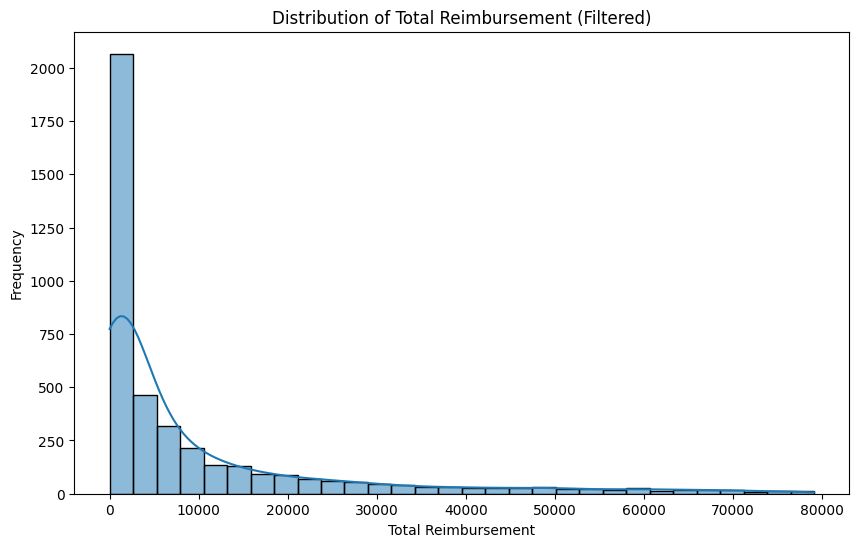

In [7]:
# Distribution of Total Reimbursement
# Calculate IQR bounds
Q1 = df['Total Reimbursement'].quantile(0.25)
Q3 = df['Total Reimbursement'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_filtered = df[(df['Total Reimbursement'] >= lower_bound) & (df['Total Reimbursement'] <= upper_bound)]

# Plot the filtered data
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['Total Reimbursement'], kde=True, bins=30)
plt.title('Distribution of Total Reimbursement (Filtered)')
plt.xlabel('Total Reimbursement')
plt.ylabel('Frequency')
plt.show()

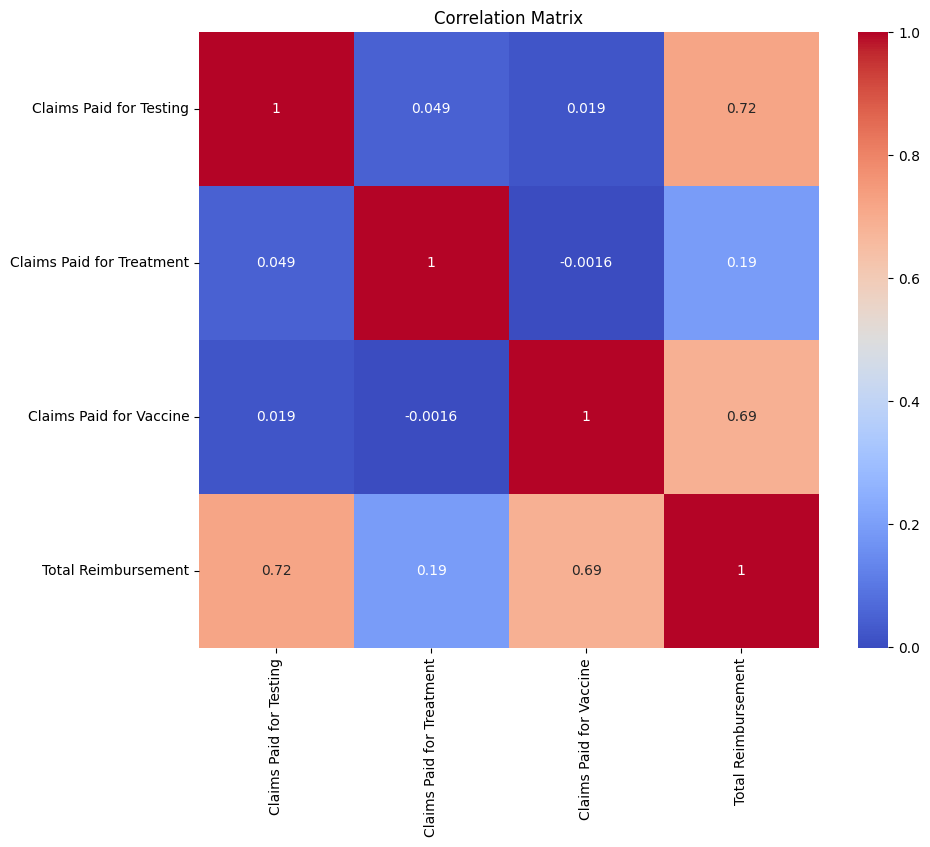

In [8]:

# Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


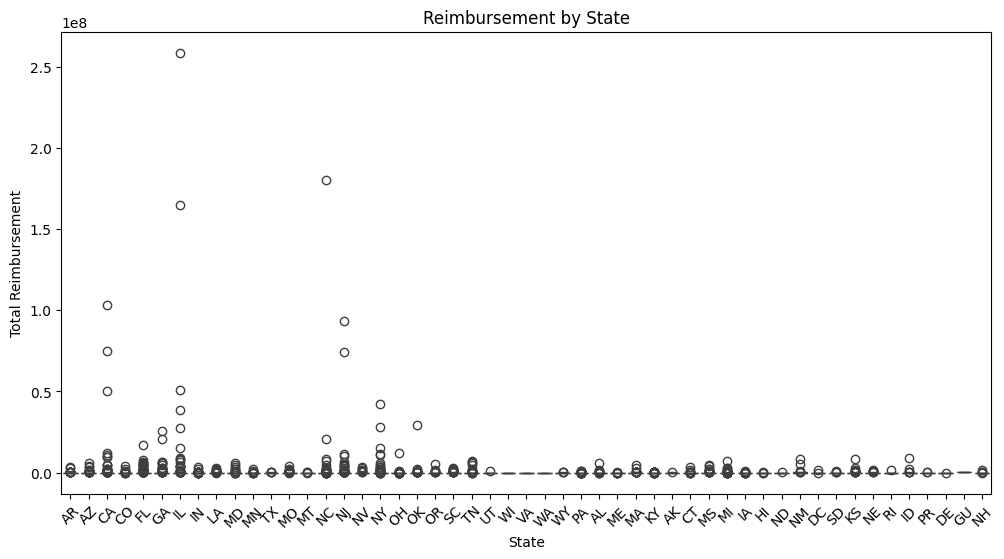

In [9]:

# Reimbursement by State
plt.figure(figsize=(12, 6))
sns.boxplot(x='State', y='Total Reimbursement', data=df)
plt.title('Reimbursement by State')
plt.xticks(rotation=45)
plt.show()

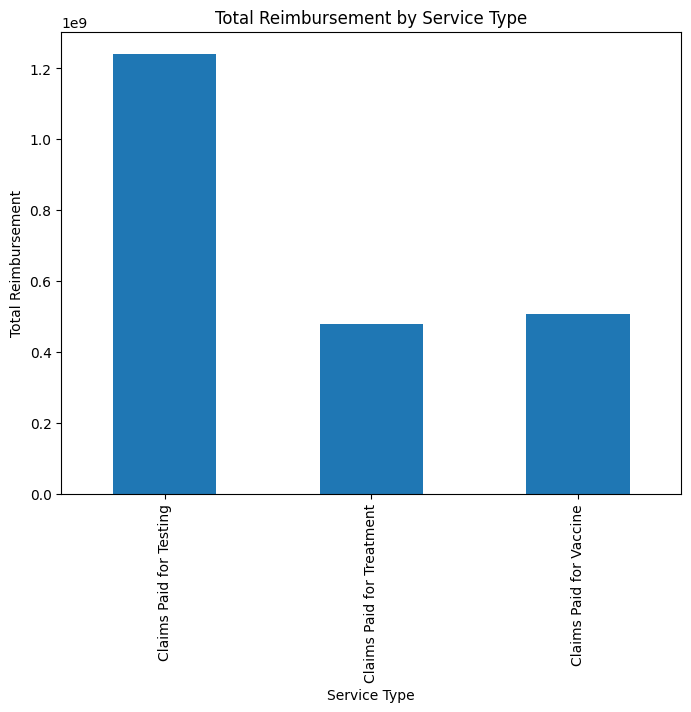

In [10]:
# Reimbursement by Service Type
service_columns = ['Claims Paid for Testing', 'Claims Paid for Treatment', 'Claims Paid for Vaccine']
service_reimbursements = df[service_columns].sum()
plt.figure(figsize=(8, 6))
service_reimbursements.plot(kind='bar')
plt.title('Total Reimbursement by Service Type')
plt.xlabel('Service Type')
plt.ylabel('Total Reimbursement')
plt.show()

In [11]:
# Check for Missing Values
print("\n--- Missing Values ---")
print(df.isnull().sum())

# Extract Coordinates from Georeferenced Column
def extract_coordinates(point_str):
    if pd.isna(point_str):
        return np.nan, np.nan
    if isinstance(point_str, str) and 'POINT' in point_str:
        coords = point_str.replace('POINT (', '').replace(')', '').split()
        try:
            return float(coords[0]), float(coords[1])
        except (ValueError, IndexError):
            return np.nan, np.nan
    else:
        return np.nan, np.nan

df[['Longitude', 'Latitude']] = df['Georeferenced Column'].apply(lambda x: pd.Series(extract_coordinates(x)))




--- Missing Values ---
Provider Name                 0
State                         0
City                          0
Claims Paid for Testing       0
Claims Paid for Treatment     0
Claims Paid for Vaccine       0
Georeferenced Column         15
Total Reimbursement           0
dtype: int64


In [12]:
# Impute Missing Longitude and Latitude
df['Longitude'] = df['Longitude'].fillna(df['Longitude'].mean())
df['Latitude'] = df['Latitude'].fillna(df['Latitude'].mean())

In [13]:
# Handle Outliers Using IQR for Total Reimbursement
Q1 = df['Total Reimbursement'].quantile(0.25)
Q3 = df['Total Reimbursement'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['Total Reimbursement'] >= lower_bound) & (df['Total Reimbursement'] <= upper_bound)]

In [14]:
# Check for Duplicate Rows
print("\n--- Duplicate Rows ---")
print(f"Number of duplicate rows: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)


--- Duplicate Rows ---
Number of duplicate rows: 0


In [15]:

# Encode Categorical Variables
le_state = LabelEncoder()
le_city = LabelEncoder()
df['State_Encoded'] = le_state.fit_transform(df['State'])
df['City_Encoded'] = le_city.fit_transform(df['City'])

In [16]:
# Features for Linear Regression
X_linear = df[['State_Encoded', 'City_Encoded', 'Claims Paid for Testing',
               'Claims Paid for Treatment', 'Claims Paid for Vaccine', 'Longitude', 'Latitude']]
y_linear = df['Total Reimbursement']

# Train-Test Split for Linear Regression
X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(
    X_linear, y_linear, test_size=0.2, random_state=42
)

# Polynomial Features (Degree 2)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_linear)
X_test_poly = poly.transform(X_test_linear)

In [17]:
# Train Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train_poly, y_train_linear)
y_pred_linear = linear_model.predict(X_test_poly)

# Evaluate Linear Regression
mse_linear = mean_squared_error(y_test_linear, y_pred_linear)
r2_linear = r2_score(y_test_linear, y_pred_linear)
print(f"\nLinear Regression Mean Squared Error: {mse_linear}")
print(f"Linear Regression R-squared: {r2_linear}")


Linear Regression Mean Squared Error: 3.852092860265791e-15
Linear Regression R-squared: 1.0


In [18]:
# Create Binary Target for High/Low Reimbursement
median_reimbursement = df['Total Reimbursement'].median()
df['High_Reimbursement'] = (df['Total Reimbursement'] > median_reimbursement).astype(int)

# Features for Logistic Regression
X_logistic = df[['State_Encoded', 'City_Encoded', 'Claims Paid for Testing',
                 'Claims Paid for Treatment', 'Claims Paid for Vaccine', 'Longitude', 'Latitude']]
y_logistic = df['High_Reimbursement']

# Train-Test Split for Logistic Regression
X_train_logistic, X_test_logistic, y_train_logistic, y_test_logistic = train_test_split(
    X_logistic, y_logistic, test_size=0.2, random_state=42
)

# Scale Features
scaler = StandardScaler()
X_train_logistic_scaled = scaler.fit_transform(X_train_logistic)
X_test_logistic_scaled = scaler.transform(X_test_logistic)

# Train Logistic Regression Model
logistic_model = LogisticRegression(solver='liblinear')
logistic_model.fit(X_train_logistic_scaled, y_train_logistic)
y_pred_logistic = logistic_model.predict(X_test_logistic_scaled)

# Evaluate Logistic Regression
accuracy_logistic = accuracy_score(y_test_logistic, y_pred_logistic)
print(f"\nLogistic Regression Accuracy: {accuracy_logistic}")
print(classification_report(y_test_logistic, y_pred_logistic))
print(confusion_matrix(y_test_logistic, y_pred_logistic))


Logistic Regression Accuracy: 0.9698795180722891
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       425
           1       1.00      0.94      0.97       405

    accuracy                           0.97       830
   macro avg       0.97      0.97      0.97       830
weighted avg       0.97      0.97      0.97       830

[[425   0]
 [ 25 380]]


In [19]:
# Cross Validation for Linear Regression
cv_scores = cross_val_score(linear_model, X_train_poly, y_train_linear, cv=5, scoring='neg_mean_squared_error')
print(f"\nCross Validation MSE: {np.mean(-cv_scores)}")


Cross Validation MSE: 1.2552187369072659e-14


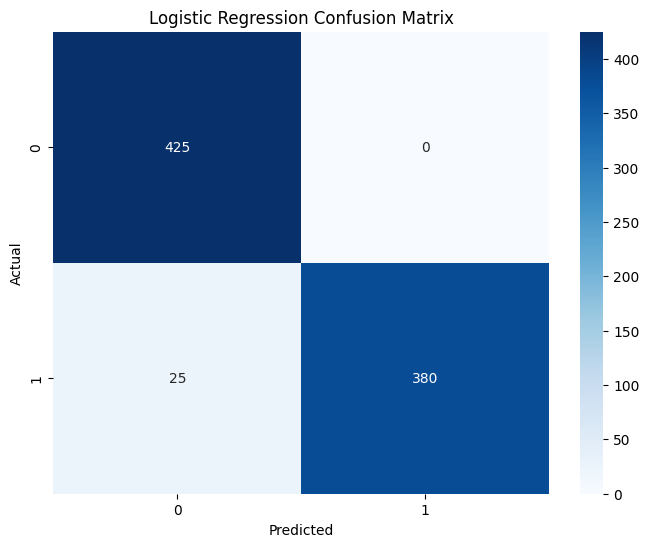

In [20]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test_logistic, y_pred_logistic)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()